In [1]:
import colour
from colour import MultiSpectralDistributions, SpectralDistribution, SpectralShape
from colour.plotting import plot_single_sd, plot_multi_sds, plot_single_cmfs, plot_multi_cmfs
import numpy as np
from scipy.ndimage import gaussian_filter

from negative_film.kodak_5207 import Kodak5207

In [2]:
kodak = Kodak5207()

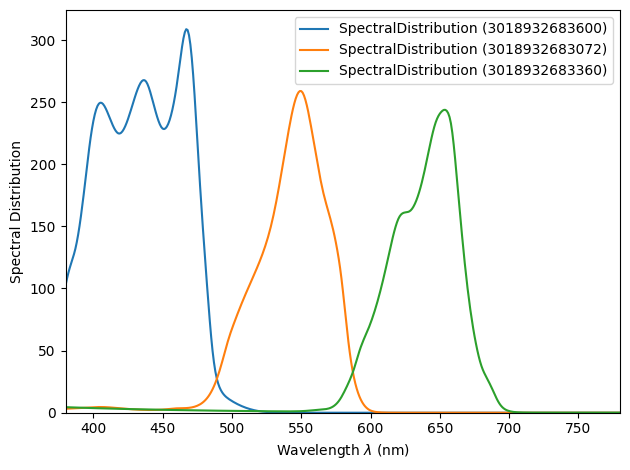

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Wavelength $\\lambda$ (nm)', ylabel='Spectral Distribution'>)

In [3]:
plot_multi_sds((kodak.yellow_sensitivity, kodak.magenta_sensitivity, kodak.cyan_sensitivity))

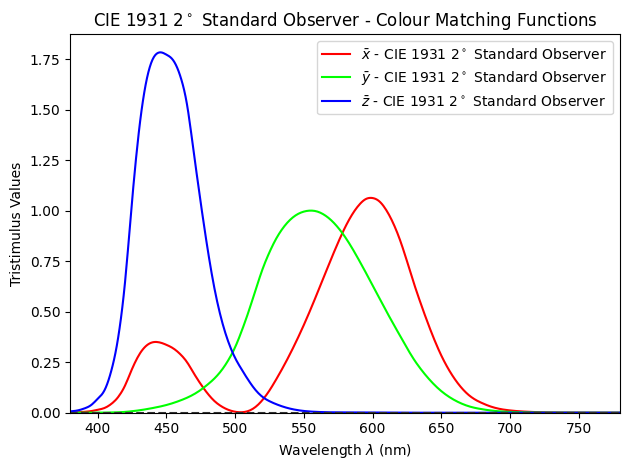

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'CIE 1931 2$^\\circ$ Standard Observer - Colour Matching Functions'}, xlabel='Wavelength $\\lambda$ (nm)', ylabel='Tristimulus Values'>)

In [4]:
xyz_cmfs = colour.MSDS_CMFS["CIE 1931 2 Degree Standard Observer"].align(colour.SPECTRAL_SHAPE_DEFAULT)

plot_single_cmfs(xyz_cmfs)

In [5]:
A = xyz_cmfs.values

In [6]:
E = A @ np.linalg.inv(A.T @ A)

In [7]:
xyz_cmfs_dual = MultiSpectralDistributions(E, colour.SPECTRAL_SHAPE_DEFAULT)

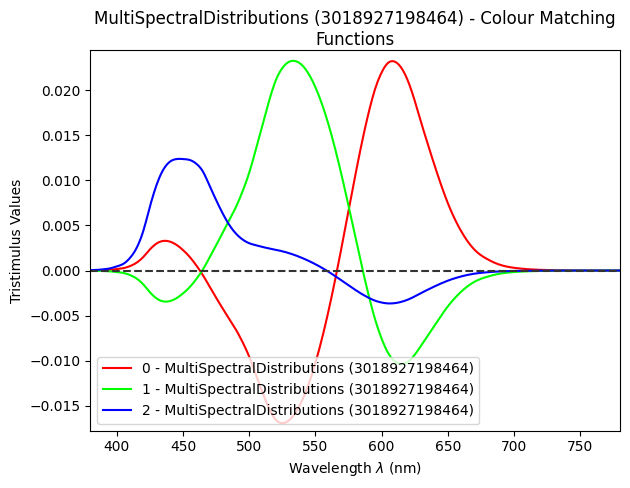

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MultiSpectralDistributions (3018927198464) - Colour Matching Functions'}, xlabel='Wavelength $\\lambda$ (nm)', ylabel='Tristimulus Values'>)

In [8]:
plot_single_cmfs(xyz_cmfs_dual)

In [9]:
D65_XYZ = colour.xyY_to_XYZ([0.3127, 0.329, 1])
D65_XYZ

array([ 0.95045593,  1.        ,  1.08905775])

In [10]:
reconstructed = SpectralDistribution(E @ D65_XYZ, colour.SPECTRAL_SHAPE_DEFAULT)

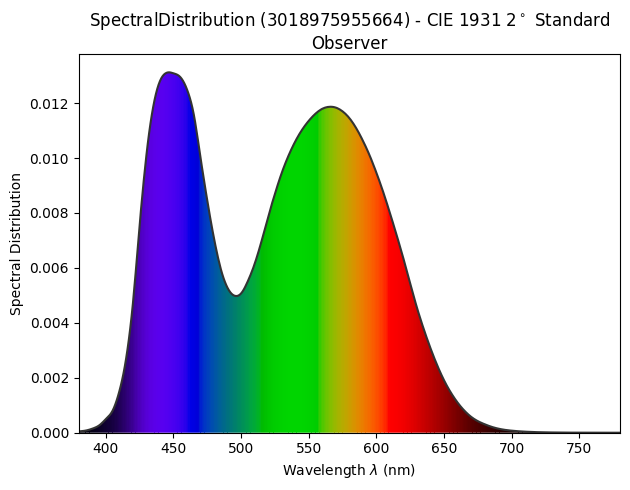

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'SpectralDistribution (3018975955664) - CIE 1931 2$^\\circ$ Standard Observer'}, xlabel='Wavelength $\\lambda$ (nm)', ylabel='Spectral Distribution'>)

In [11]:
plot_single_sd(reconstructed)

In [12]:
sensitivity = np.stack(
    (kodak.cyan_sensitivity.values, kodak.magenta_sensitivity.values, kodak.yellow_sensitivity.values)).T

In [13]:
sensitivity.T @ reconstructed.values

array([  56.13837031,  148.30600911,  178.83533871])

In [14]:
sensitivity.T @ E @ D65_XYZ

array([  56.13837031,  148.30600911,  178.83533871])

In [15]:
middle_gray = colour.xyY_to_XYZ([0.3127, 0.329, 0.18])
middle_gray

array([ 0.17108207,  0.18      ,  0.1960304 ])

In [16]:
target_density = [0.8, 1.2, 1.6]

target_log_exposure = np.array([np.interp(target_density[0], kodak.red_density_curve, kodak.red_log_exposure),
                                np.interp(target_density[1], kodak.green_density_curve, kodak.green_log_exposure),
                                np.interp(target_density[2], kodak.blue_density_curve, kodak.blue_log_exposure), ])
target_exposure = 10 ** target_log_exposure

target_exposure

array([ 0.03210493,  0.02166958,  0.04138414])

In [17]:
film_matrix_prev = (E.T @ sensitivity).T
film_matrix_prev

array([[ 162.79356882,  -72.98426276,  -23.51158997],
       [-117.20118818,  244.28144941,   14.15822407],
       [  13.75858497,  -16.75272491,  167.58627801]])

In [18]:
factors = target_exposure / (film_matrix_prev @ middle_gray)
factors

array([ 0.00317716,  0.00081174,  0.00128561])

In [19]:
film_matrix = (film_matrix_prev.T * factors).T
film_matrix

array([[ 0.51722163, -0.23188287, -0.07470014],
       [-0.09513738,  0.19829403,  0.01149286],
       [ 0.01768813, -0.02153741,  0.21545003]])

In [20]:
film_matrix @ middle_gray

array([ 0.03210493,  0.02166958,  0.04138414])

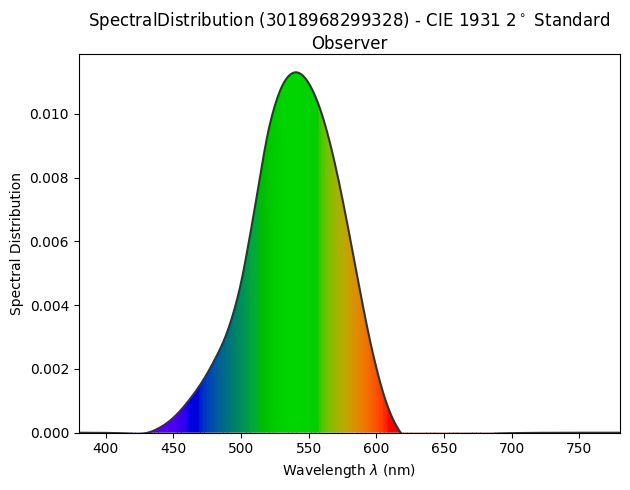

(array([   3.21405396,  134.48660804,   12.91480547]),
 array([   3.21405396,  134.48660804,   12.91480547]),
 array([ 0.01021157,  0.10916872,  0.01660336]))

In [21]:
rgb = (0, 1, 0)
xyz = colour.sRGB_to_XYZ(rgb)
spectrum = SpectralDistribution(E @ xyz, colour.SPECTRAL_SHAPE_DEFAULT)
plot_single_sd(spectrum)
sensitivity.T @ spectrum.values, film_matrix_prev @ xyz, film_matrix @ xyz


In [22]:
status_a_sensitivities = np.array([[-62.232, -29.150, -19.198],
                                   [-59.532, -26.950, -15.398],
                                   [-56.832, -24.750, -11.598],
                                   [-54.132, -22.550, -7.798],
                                   [-51.432, -20.350, -3.998],
                                   [-48.732, -18.150, -0.198],
                                   [-46.032, -15.950, 3.602],
                                   [-43.332, -13.750, 4.819],
                                   [-40.632, -11.550, 5.000],
                                   [-37.932, -9.350, 4.912],
                                   [-35.232, -7.150, 4.620],
                                   [-32.532, -4.950, 4.040],
                                   [-29.832, -2.750, 2.989],
                                   [-27.132, -0.550, 1.566],
                                   [-24.432, 1.650, 0.165],
                                   [-21.732, 3.822, -1.235],
                                   [-19.032, 4.782, -2.635],
                                   [-16.332, 5.000, -4.035],
                                   [-13.632, 4.906, -5.435],
                                   [-10.932, 4.644, -6.835],
                                   [-8.232, 4.221, -8.235],
                                   [-5.532, 3.609, -9.635],
                                   [-2.832, 2.766, -11.035],
                                   [-0.132, 1.579, -12.435],
                                   [2.568, -0.121, -13.835],
                                   [4.638, -1.821, -15.235],
                                   [5.000, -3.521, -16.635],
                                   [4.871, -5.221, -18.035],
                                   [4.604, -6.921, -19.435],
                                   [4.286, -8.621, -20.835],
                                   [3.900, -10.321, -22.235],
                                   [3.551, -12.021, -23.635],
                                   [3.165, -13.721, -25.035],
                                   [2.776, -15.421, -26.435],
                                   [2.383, -17.121, -27.835],
                                   [1.970, -18.821, -29.235],
                                   [1.551, -20.521, -30.635],
                                   [1.141, -22.221, -32.035],
                                   [0.741, -23.921, -33.435],
                                   [0.341, -25.621, -34.835],
                                   [-0.059, -27.321, -36.235],
                                   [-0.459, -29.021, -37.635],
                                   [-0.859, -30.721, -39.035], ])
status_a_sensitivities = 10 ** status_a_sensitivities

status_a_sensitivities = MultiSpectralDistributions(status_a_sensitivities,
                                                           SpectralShape(360, 780, 10)).align(
    colour.SPECTRAL_SHAPE_DEFAULT, interpolator=colour.LinearInterpolator)

status_a_sensitivities.normalise()

MultiSpectralDistributions([[  3.80000000e+02,   1.47231250e-62,   1.77827941e-30,
                               2.52348077e-17],
                            [  3.81000000e+02,   7.51155043e-61,   2.97842808e-29,
                               1.59447986e-14],
                            [  3.82000000e+02,   1.48758696e-60,   5.77902822e-29,
                               3.18643624e-14],
                            ..., 
                            [  7.78000000e+02,   1.80192543e-06,   2.05767859e-35,
                               5.37284644e-44],
                            [  7.79000000e+02,   1.59274590e-06,   1.12389321e-35,
                               3.14770893e-44],
                            [  7.80000000e+02,   1.38356638e-06,   1.90107828e-36,
                               9.22571427e-45]],
                           ['0', '1', '2'],
                           SpragueInterpolator,
                           {},
                           Extrapolator,
               

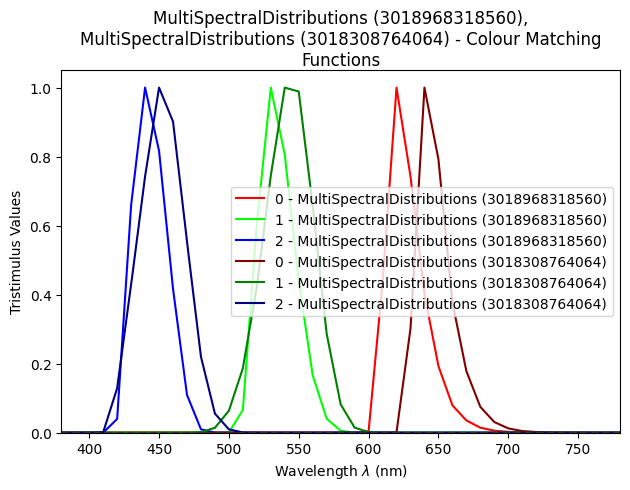

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MultiSpectralDistributions (3018968318560), MultiSpectralDistributions (3018308764064) - Colour Matching Functions'}, xlabel='Wavelength $\\lambda$ (nm)', ylabel='Tristimulus Values'>)

In [23]:
status_m_sensitivities = np.array([[-65.491, -10.508, -10.397],
                                   [-62.891, -9.448, -7.897],
                                   [-60.291, -8.388, -5.397],
                                   [-57.691, -7.328, -2.897],
                                   [-55.091, -6.268, -0.397],
                                   [-52.491, -5.208, 2.103],
                                   [-49.891, -4.148, 4.111],
                                   [-47.291, -3.088, 4.632],
                                   [-44.691, -2.028, 4.871],
                                   [-42.091, -0.968, 5.000],
                                   [-39.491, 0.092, 4.955],
                                   [-36.891, 1.152, 4.743],
                                   [-34.291, 2.207, 4.343],
                                   [-31.691, 3.156, 3.743],
                                   [-29.091, 3.804, 2.990],
                                   [-26.491, 4.272, 1.852],
                                   [-23.891, 4.626, -0.348],
                                   [-21.291, 4.872, -2.548],
                                   [-18.691, 5.000, -4.748],
                                   [-16.091, 4.995, -6.948],
                                   [-13.491, 4.818, -9.148],
                                   [-10.891, 4.458, -11.348],
                                   [-8.291, 3.915, -13.548],
                                   [-5.691, 3.172, -15.748],
                                   [-3.091, 2.239, -17.948],
                                   [-0.491, 1.070, -20.148],
                                   [2.109, -0.130, -22.348],
                                   [4.479, -1.330, -24.548],
                                   [5.000, -2.530, -26.748],
                                   [4.899, -3.730, -28.948],
                                   [4.578, -4.930, -31.148],
                                   [4.252, -6.130, -33.348],
                                   [3.875, -7.330, -35.548],
                                   [3.491, -8.530, -37.748],
                                   [3.099, -9.730, -39.948],
                                   [2.687, -10.930, -42.148],
                                   [2.269, -12.130, -44.348],
                                   [1.859, -13.330, -46.548],
                                   [1.449, -14.530, -48.748],
                                   [1.054, -15.730, -50.948],
                                   [0.654, -16.930, -53.148],
                                   [0.265, -18.130, -55.348],
                                   [-0.135, -19.330, -57.548],
                                   ])
status_m_sensitivities = 10 ** status_m_sensitivities

status_m_sensitivities = MultiSpectralDistributions(status_m_sensitivities,
                                                           SpectralShape(360, 780, 10)).align(
    colour.SPECTRAL_SHAPE_DEFAULT, interpolator=colour.LinearInterpolator)

status_m_sensitivities.normalise()

plot_multi_cmfs((status_a_sensitivities, status_m_sensitivities))

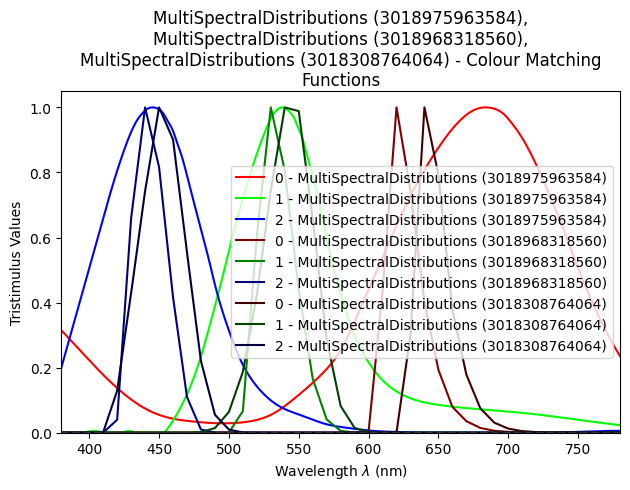

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MultiSpectralDistributions (3018975963584), MultiSpectralDistributions (3018968318560), MultiSpectralDistributions (3018308764064) - Colour Matching Functions'}, xlabel='Wavelength $\\lambda$ (nm)', ylabel='Tristimulus Values'>)

In [24]:
dye_densities = np.stack(
    (kodak.cyan_spectral_density.values, kodak.magenta_spectral_density.values, kodak.yellow_spectral_density.values)).T

plot_multi_cmfs((MultiSpectralDistributions(dye_densities, colour.SPECTRAL_SHAPE_DEFAULT),
                                 status_a_sensitivities, status_m_sensitivities))

In [25]:
density_conversion = status_m_sensitivities.values.T @ dye_densities
density_conversion

array([[  2.37252929e+01,   2.46677012e+00,   5.20334324e-03],
       [  4.49081491e+00,   3.88716937e+01,   3.68828158e+00],
       [  2.41981649e+00,   1.86110453e+00,   3.65049943e+01]])

In [26]:
norm_factors = status_m_sensitivities.values.sum(axis=0)
norm_factors

array([ 27.78612308,  44.66468141,  40.42998265])

In [27]:
density_conversion = density_conversion.T / norm_factors
density_conversion

array([[  8.53854018e-01,   1.00545101e-01,   5.98520288e-02],
       [  8.87770529e-02,   8.70300482e-01,   4.60327808e-02],
       [  1.87264097e-04,   8.25771384e-02,   9.02918872e-01]])

In [28]:
density_conversion = np.linalg.inv(density_conversion)
density_conversion

array([[ 1.18469721, -0.13004494, -0.07190037],
       [-0.1214222 ,  1.16794232, -0.05149551],
       [ 0.01085906, -0.10678809,  1.11224369]])

(3, 401) (401,)


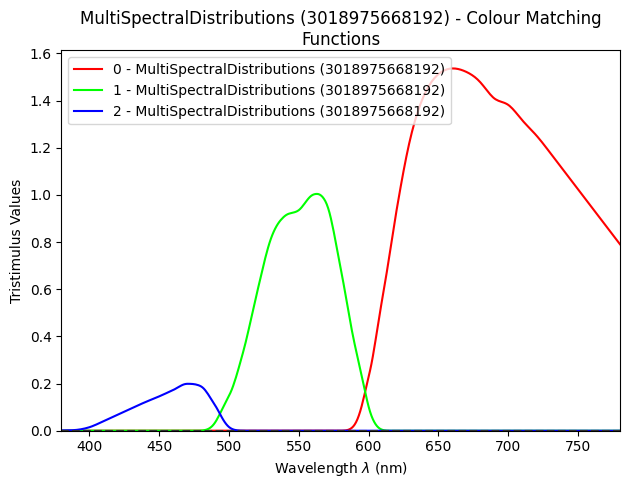

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MultiSpectralDistributions (3018975668192) - Colour Matching Functions'}, xlabel='Wavelength $\\lambda$ (nm)', ylabel='Tristimulus Values'>)

In [29]:
printer_light = SpectralDistribution({360: 0.0000,
                                             362: 0.0000,
                                             364: 0.0000,
                                             366: 0.0000,
                                             368: 0.0001,
                                             370: 0.0001,
                                             372: 0.0002,
                                             374: 0.0005,
                                             376: 0.0007,
                                             378: 0.0010,
                                             380: 0.0013,
                                             382: 0.0014,
                                             384: 0.0016,
                                             386: 0.0018,
                                             388: 0.0022,
                                             390: 0.0030,
                                             392: 0.0043,
                                             394: 0.0061,
                                             396: 0.0084,
                                             398: 0.0113,
                                             400: 0.0147,
                                             402: 0.0189,
                                             404: 0.0237,
                                             406: 0.0290,
                                             408: 0.0345,
                                             410: 0.0399,
                                             412: 0.0451,
                                             414: 0.0505,
                                             416: 0.0560,
                                             418: 0.0614,
                                             420: 0.0669,
                                             422: 0.0724,
                                             424: 0.0779,
                                             426: 0.0834,
                                             428: 0.0889,
                                             430: 0.0944,
                                             432: 0.0998,
                                             434: 0.1052,
                                             436: 0.1106,
                                             438: 0.1159,
                                             440: 0.1211,
                                             442: 0.1261,
                                             444: 0.1309,
                                             446: 0.1357,
                                             448: 0.1406,
                                             450: 0.1456,
                                             452: 0.1508,
                                             454: 0.1562,
                                             456: 0.1616,
                                             458: 0.1671,
                                             460: 0.1725,
                                             462: 0.1787,
                                             464: 0.1856,
                                             466: 0.1921,
                                             468: 0.1969,
                                             470: 0.1989,
                                             472: 0.1988,
                                             474: 0.1981,
                                             476: 0.1964,
                                             478: 0.1933,
                                             480: 0.1885,
                                             482: 0.1802,
                                             484: 0.1684,
                                             486: 0.1563,
                                             488: 0.1468,
                                             490: 0.1428,
                                             492: 0.1428,
                                             494: 0.1439,
                                             496: 0.1471,
                                             498: 0.1534,
                                             500: 0.1637,
                                             502: 0.1825,
                                             504: 0.2114,
                                             506: 0.2476,
                                             508: 0.2883,
                                             510: 0.3307,
                                             512: 0.3762,
                                             514: 0.4265,
                                             516: 0.4794,
                                             518: 0.5325,
                                             520: 0.5836,
                                             522: 0.6338,
                                             524: 0.6842,
                                             526: 0.7325,
                                             528: 0.7764,
                                             530: 0.8137,
                                             532: 0.8434,
                                             534: 0.8669,
                                             536: 0.8852,
                                             538: 0.8993,
                                             540: 0.9104,
                                             542: 0.9179,
                                             544: 0.9220,
                                             546: 0.9248,
                                             548: 0.9285,
                                             550: 0.9352,
                                             552: 0.9469,
                                             554: 0.9621,
                                             556: 0.9779,
                                             558: 0.9915,
                                             560: 1.0000,
                                             562: 1.0036,
                                             564: 1.0032,
                                             566: 0.9969,
                                             568: 0.9832,
                                             570: 0.9602,
                                             572: 0.9235,
                                             574: 0.8728,
                                             576: 0.8134,
                                             578: 0.7502,
                                             580: 0.6882,
                                             582: 0.6252,
                                             584: 0.5589,
                                             586: 0.4947,
                                             588: 0.4376,
                                             590: 0.3930,
                                             592: 0.3627,
                                             594: 0.3436,
                                             596: 0.3334,
                                             598: 0.3297,
                                             600: 0.3304,
                                             602: 0.3467,
                                             604: 0.3866,
                                             606: 0.4423,
                                             608: 0.5062,
                                             610: 0.5705,
                                             612: 0.6370,
                                             614: 0.7101,
                                             616: 0.7863,
                                             618: 0.8623,
                                             620: 0.9345,
                                             622: 1.0029,
                                             624: 1.0690,
                                             626: 1.1317,
                                             628: 1.1898,
                                             630: 1.2424,
                                             632: 1.2890,
                                             634: 1.3303,
                                             636: 1.3667,
                                             638: 1.3985,
                                             640: 1.4261,
                                             642: 1.4499,
                                             644: 1.4700,
                                             646: 1.4867,
                                             648: 1.5005,
                                             650: 1.5118,
                                             652: 1.5206,
                                             654: 1.5273,
                                             656: 1.5320,
                                             658: 1.5348,
                                             660: 1.5359,
                                             662: 1.5355,
                                             664: 1.5336,
                                             666: 1.5305,
                                             668: 1.5263,
                                             670: 1.5212,
                                             672: 1.5151,
                                             674: 1.5079,
                                             676: 1.4994,
                                             678: 1.4892,
                                             680: 1.4771,
                                             682: 1.4631,
                                             684: 1.4480,
                                             686: 1.4332,
                                             688: 1.4197,
                                             690: 1.4088,
                                             692: 1.4015,
                                             694: 1.3965,
                                             696: 1.3926,
                                             698: 1.3880,
                                             700: 1.3813,
                                             702: 1.3714,
                                             704: 1.3590,
                                             706: 1.3450,
                                             708: 1.3305,
                                             710: 1.3163,
                                             712: 1.3030,
                                             714: 1.2904,
                                             716: 1.2781,
                                             718: 1.2656,
                                             720: 1.2526,
                                             722: 1.2387,
                                             724: 1.2242,
                                             726: 1.2091,
                                             728: 1.1937,
                                             730: 1.1782, }).align(colour.SPECTRAL_SHAPE_DEFAULT, extrapolator_kwargs={'method': 'linear'})

bg_cutoff = 493
gr_cutoff = 598
sigma = 5

blue_factors = np.where(printer_light.wavelengths <= bg_cutoff, 1., 0.)
blue_factors = gaussian_filter(blue_factors, sigma=sigma)

green_factors = np.where((bg_cutoff < printer_light.wavelengths) & (printer_light.wavelengths < gr_cutoff), 1, 0).astype(float)
green_factors = gaussian_filter(green_factors, sigma=sigma)

red_factors = np.where(gr_cutoff <= printer_light.wavelengths, 1, 0).astype(float)
red_factors = gaussian_filter(red_factors, sigma=sigma)

factors = np.stack((red_factors, green_factors, blue_factors), axis=1).T

printer_lights = (factors * printer_light.values).T
printer_lights = MultiSpectralDistributions(printer_lights, colour.SPECTRAL_SHAPE_DEFAULT)

plot_single_cmfs(printer_lights)